In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras as K
import tensorflow as tf

C:\Users\admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<font color=blue>
# 1. Cleaning, processing and exploring the data 

## <font color=orange> A. Cleaning

In [2]:
df =  pd.read_csv('Train_Set.csv')
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
df[['funder','installer']]=df[['funder','installer']].applymap(lambda x:x.lower() if isinstance(x, str) else x)
#This function is to lower case all etries in 'funder' and 'installer'

### We see that some rows in 'funder' and 'installer' have nan values. Let's check for such values in other columns
<font color=black>--------------------------------------------------------------------------------------------------</font>
### Let's start with features that are numerical 

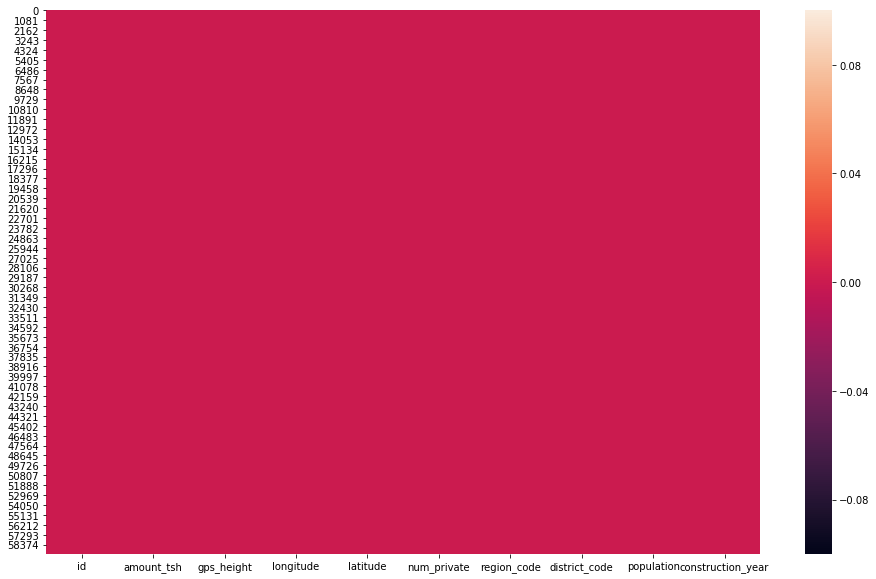

In [4]:
plt.figure(figsize=[16,10])
df_num = df.select_dtypes(include='number', exclude=object)
sns.heatmap(df_num.isna())

In [5]:
df_num[df_num.isna().any(axis=1)]

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year


### None of the numberical values is null. 

<font color=black>---------------------------------------------------------------------------------------------</font>
### Next, we'll proceed to specify value in non-numerical features (categorical vars)
1. = "NoData" for all "NaN" values 
2. = "Zero" for all "0" values 

In [6]:
df_obj = df.select_dtypes(exclude='number')
df_obj.replace(value=['nodata/none','nodata/none','nodata/none','nodata/none','zero','zero','zero'], 
                                            to_replace=['NaN','None','none',np.NaN,'0',0,0.0], inplace=True)
df_cleaned = pd.concat(objs=[df_obj, df_num], axis=1)

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


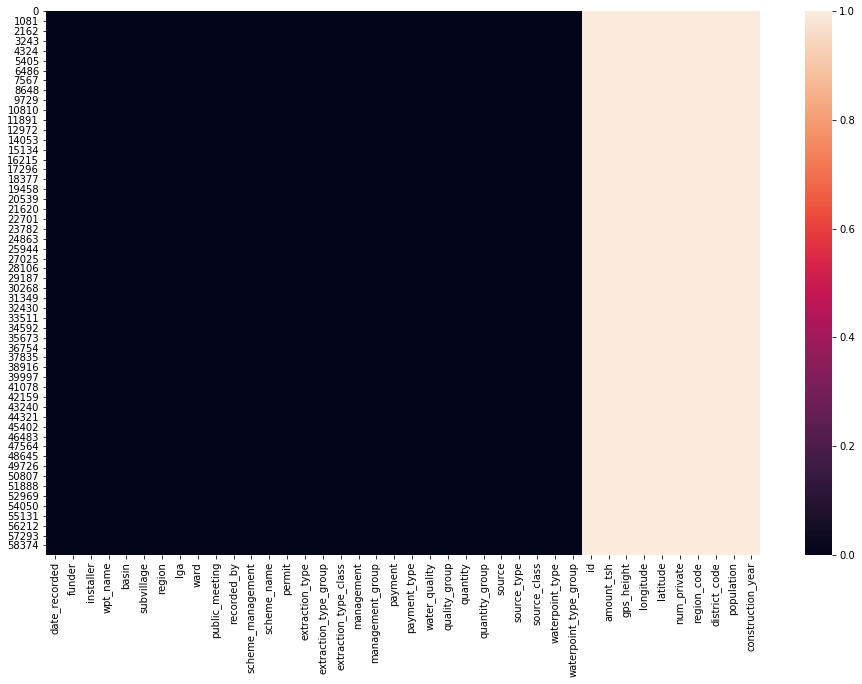

In [7]:
plt.figure(figsize=[16,10])
df_check = df_cleaned.applymap(lambda x:1 if ((isinstance(x, int) or isinstance(x, float)) 
                                              and not isinstance(x, bool)) else 0)
sns.heatmap(df_check)

### Now we ended up with non NaN values in the dataframe & the categorical columns only include object dtype and the numerical columns only include numeric dtype

In [8]:
print('Total number of entries = {}'.format(df_cleaned.count()[0]))
print('Total number of distinct waterpoint ids = {}'.format(df_cleaned.id.nunique()))

Total number of entries = 59400
Total number of distinct waterpoint ids = 59400


# Great, there seems to be no duplicate entries in our dataset

<font color=black>----------------------------------------------------------------------------------------------------</font>
### Let's perform more exploratory data analysis below

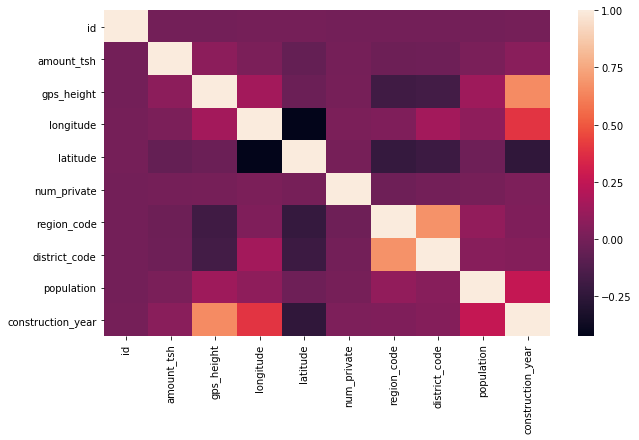

In [9]:
plt.figure(figsize=[10,6])
sns.heatmap(df_cleaned.corr())

### We should see that the following pairs of features have high correlation and can appear to have a stronger effect on our model prediction than it should have
1. region code v.s district code (~70% correlation)
2. gps heigh and constrution year (~70% correlation)
    * we will determine whether to remove 1 feature from each pair later after going through the p-value score of the features 
    * this is only necessary if we happen to chose logistic regression as out classifier). 
    * we ought to use statsmodels.formula.api for this

### Another interesting thing to note is odd value from construction_year
* we see that there shouldn't be a year 0. This must be a mistake and for sake of sense we will assign the value of such year to be 1950, which is earlier than all entires that has values for 'construction_year'

In [10]:
print(df_cleaned['construction_year'].unique())

[1999 2010 2009 1986    0 2011 1987 1991 1978 1992 2008 1974 2000 2002
 2004 1972 2003 1980 2007 1973 1985 1970 1995 2006 1962 2005 1997 2012
 1996 1977 1983 1984 1990 1982 1976 1988 1989 1975 1960 1961 1998 1963
 1971 1994 1968 1993 2001 1979 1967 2013 1969 1981 1964 1966 1965]


In [11]:
df_cleaned['construction_year'].replace(to_replace=0, value=1950, inplace=True)
df_cleaned['construction_year'].unique()

array([1999, 2010, 2009, 1986, 1950, 2011, 1987, 1991, 1978, 1992, 2008,
       1974, 2000, 2002, 2004, 1972, 2003, 1980, 2007, 1973, 1985, 1970,
       1995, 2006, 1962, 2005, 1997, 2012, 1996, 1977, 1983, 1984, 1990,
       1982, 1976, 1988, 1989, 1975, 1960, 1961, 1998, 1963, 1971, 1994,
       1968, 1993, 2001, 1979, 1967, 2013, 1969, 1981, 1964, 1966, 1965],
      dtype=int64)

### Even more Data Exploratory Analysis follows

In [12]:
df_label = pd.read_csv('Train_Labels.csv')
df_label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


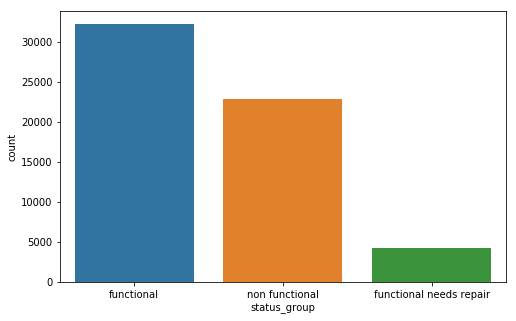

In [13]:
plt.figure(figsize=[8,5])
sns.countplot(data=df_label, x='status_group')

#### For this problem we will need to use a multiclass version of the classifier (due to us having 3 classes to predict). We are going to use the multi_class = 'ovr' option (ovr is short for one-versus-rest)

In [14]:
df_join = pd.merge(left=df_cleaned, right=df_label, how='inner', on='id')
df_join.head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
0,2011-03-14,roman,roman,nodata/none,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,True,...,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,functional
1,2013-03-06,grumeti,grumeti,Zahanati,Lake Victoria,Nyamara,Mara,Serengeti,Natta,nodata/none,...,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,functional
2,2013-02-25,lottery club,world vision,Kwa Mahundi,Pangani,Majengo,Manyara,Simanjiro,Ngorika,True,...,25.0,686,37.460664,-3.821329,0,21,4,250,2009,functional
3,2013-01-28,unicef,unicef,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,True,...,0.0,263,38.486161,-11.155298,0,90,63,58,1986,non functional
4,2011-07-13,action in a,artisan,Shuleni,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,True,...,0.0,0,31.130847,-1.825359,0,18,1,0,1950,functional


In [15]:
df_join.columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'id',
       'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year',
       'status_group'],
      dtype='object')

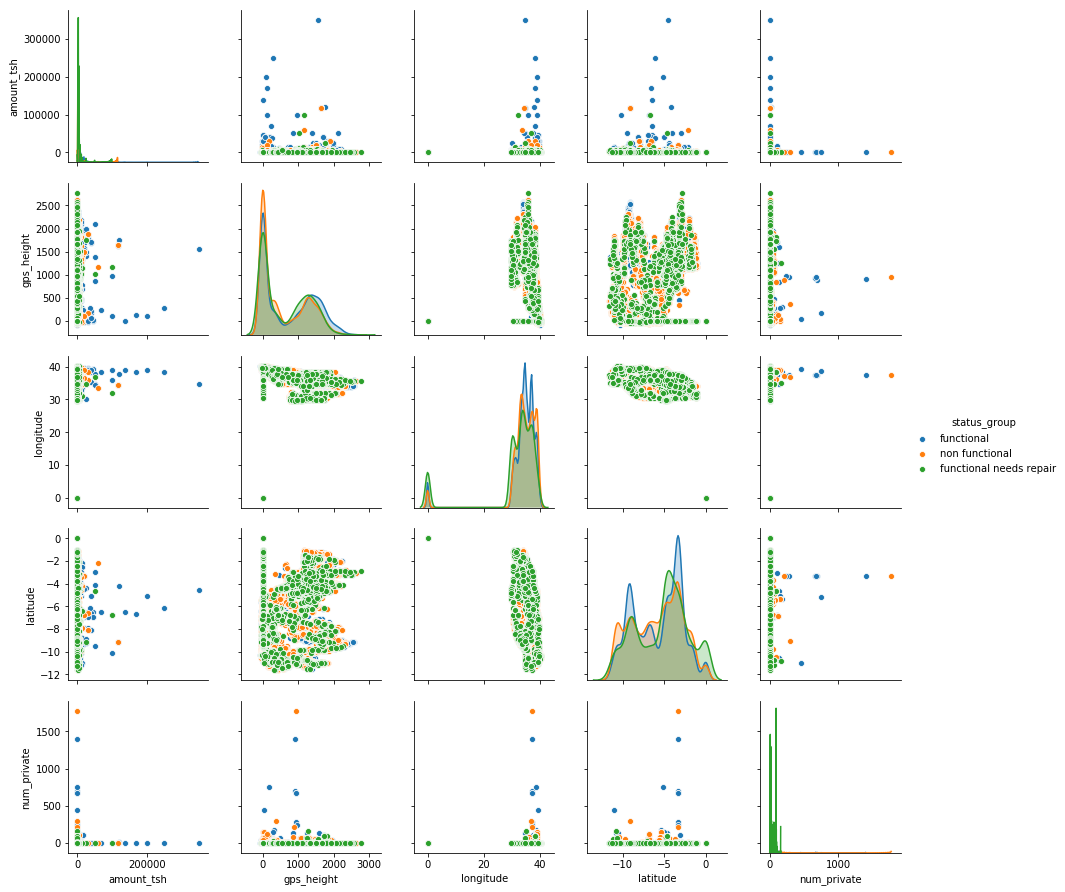

In [16]:
sns.pairplot(data=df_join.drop(labels=['id'], axis=1), hue='status_group', 
             x_vars=df.select_dtypes(exclude=object).columns[1:6], 
             y_vars=df.select_dtypes(exclude=object).columns[1:6])

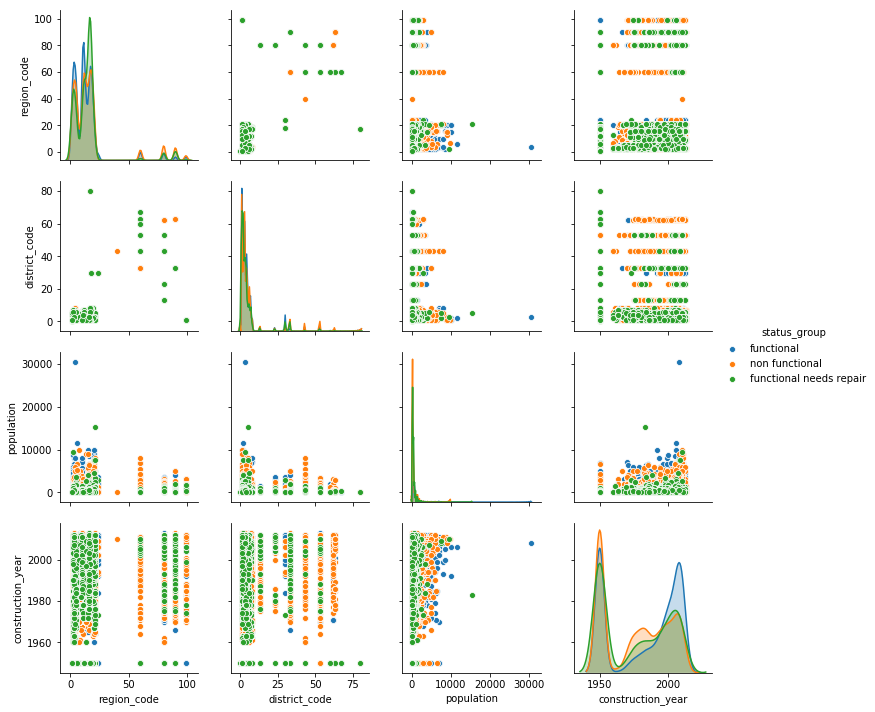

In [17]:
sns.pairplot(data=df_join.drop(labels=['id'], axis=1), hue='status_group', 
             x_vars=df.select_dtypes(exclude=object).columns[6:12], 
             y_vars=df.select_dtypes(exclude=object).columns[6:12])

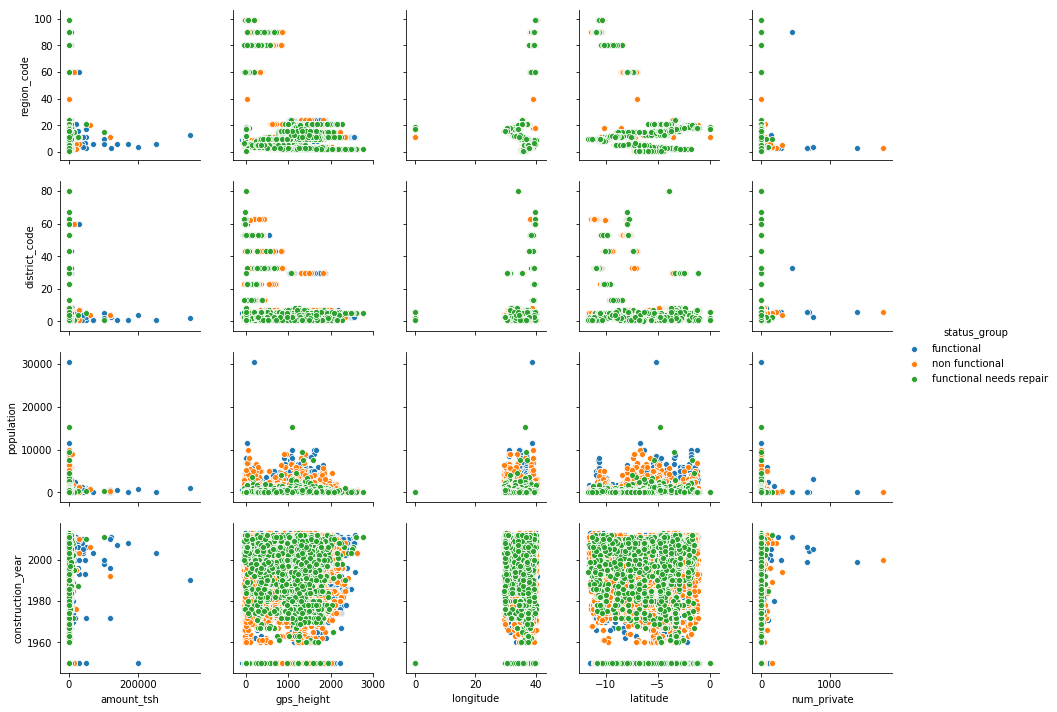

In [18]:
sns.pairplot(data=df_join.drop(labels=['id'], axis=1), hue='status_group', 
             x_vars=df.select_dtypes(exclude=object).columns[1:6], 
             y_vars=df.select_dtypes(exclude=object).columns[6:12])

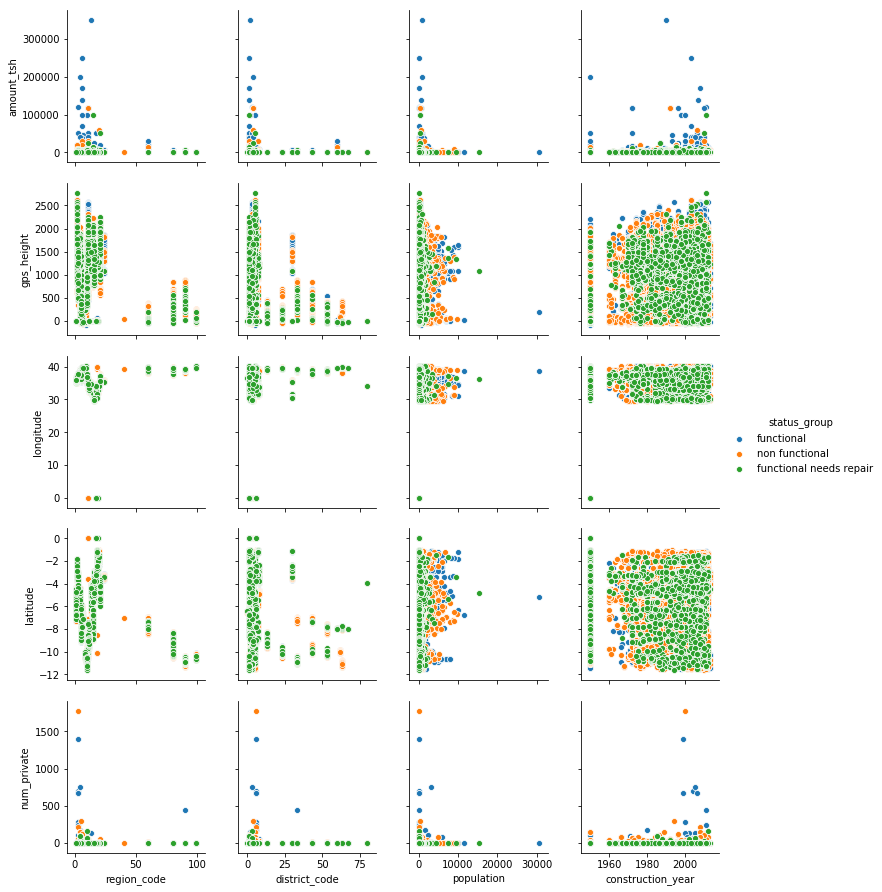

In [19]:
sns.pairplot(data=df_join.drop(labels=['id'], axis=1), hue='status_group', 
             x_vars=df.select_dtypes(exclude=object).columns[6:12], 
             y_vars=df.select_dtypes(exclude=object).columns[1:6])

### We see 2 observations from the above pairplots
### <font color = red> A. Observation 1:
* Some entries have latitude & longitude at 0 and 0 respectively. This should not be the case because Tanzania doesn't lie on either Latitude 0 or logitude 0 
<img src="TanzaniaMap.gif">

In [20]:
df_join.where((df_join.longitude==0) | (df_join.latitude==0)).dropna().head(10)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
21,2013-02-10,dwsp,dwe,Muungano,Lake Victoria,Ibabachegu,Shinyanga,Bariadi,Ikungulyabashashi,nodata/none,...,0.0,0.0,0.0,-2.000000e-08,0.0,17.0,1.0,0.0,1950.0,functional
53,2011-08-01,government of tanzania,government,Polisi,Lake Victoria,Center,Mwanza,Geita,Nyang'hwale,True,...,0.0,0.0,0.0,-2.000000e-08,0.0,19.0,6.0,0.0,1950.0,non functional
168,2013-01-30,wvt,wvt,Wvt Tanzania,Lake Victoria,Ilula,Shinyanga,Bariadi,Chinamili,zero,...,0.0,0.0,0.0,-2.000000e-08,0.0,17.0,1.0,0.0,1950.0,functional
177,2013-01-17,netherlands,dwe,Kikundi Cha Wakina Mama,Lake Victoria,Mahaha,Shinyanga,Bariadi,Bunamhala,nodata/none,...,0.0,0.0,0.0,-2.000000e-08,0.0,17.0,1.0,0.0,1950.0,non functional
253,2012-10-29,hesawa,dwe,Kwakisusi,Lake Victoria,Nyamatala,Mwanza,Magu,Malili,True,...,0.0,0.0,0.0,-2.000000e-08,0.0,19.0,2.0,0.0,1950.0,functional needs repair
256,2011-07-18,hesawa,dwe,Bombani,Lake Victoria,Ujamaa,Mwanza,Geita,Kalangalala,True,...,0.0,0.0,0.0,-2.000000e-08,0.0,19.0,6.0,0.0,1950.0,non functional
285,2012-10-25,ridep,dwe,Nyanguruma,Lake Victoria,Nyalwashi,Mwanza,Magu,Shigala,True,...,0.0,0.0,0.0,-2.000000e-08,0.0,19.0,2.0,0.0,1950.0,functional
301,2011-07-18,government of tanzania,government,Nersing College,Lake Victoria,Nyanza,Mwanza,Geita,Kalangalala,True,...,0.0,0.0,0.0,-2.000000e-08,0.0,19.0,6.0,0.0,1950.0,functional
306,2011-07-30,plan international,plan internationa,Petro,Lake Victoria,Mwabasabi,Mwanza,Geita,Kasamwa,True,...,0.0,0.0,0.0,-2.000000e-08,0.0,19.0,6.0,0.0,1950.0,functional
321,2013-01-22,dwsp,dwe,Upendo,Lake Victoria,Sunzula Madukani,Shinyanga,Bariadi,Zagayu,nodata/none,...,0.0,0.0,0.0,-2.000000e-08,0.0,17.0,1.0,0.0,1950.0,functional needs repair


In [21]:
print('Number of such entries')
print(df_join.where((df_join.longitude==0) | (df_join.latitude==0)).dropna().count()[0])
print('Number of all entries')
print(df_join.count()[0])

Number of such entries
1812
Number of all entries
59400


### There is no way to know where such erroneous entries come from. A closer look at these entries also show that these coincide with the entries where year is wrong (imputed with 1950) or no population (unlikely)
-------------------
### In a real life Data Science project I would go ahead to double check with those who collected the data about these entries. For now let's keep these entries

### <font color=blue>Observation 2
### Some of the variables that seem to have the most ability to separate the classes are
1. population
2. gps_height (not that clear cut)
3. amount_tsh
4. num_private
5. year constructed (those constructed in the year 200x seems to be more functional)  
**But those with construction year = 0 are rare and seem not functional

### Let's try some feature engineering and ad new variables

In [22]:
df_join.where(df.population==0).dropna().head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
4,2011-07-13,action in a,artisan,Shuleni,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,True,...,0.0,0.0,31.130847,-1.825359,0.0,18.0,1.0,0.0,1950.0,functional
6,2012-10-01,dwsp,dwsp,Kwa Ngomho,Internal,Ishinabulandi,Shinyanga,Shinyanga Rural,Samuye,True,...,0.0,0.0,33.362410,-3.766365,0.0,17.0,3.0,0.0,1950.0,non functional
7,2012-10-09,rwssp,dwe,Tushirikiane,Lake Tanganyika,Nyawishi Center,Shinyanga,Kahama,Chambo,True,...,0.0,0.0,32.620617,-4.226198,0.0,17.0,3.0,0.0,1950.0,non functional
8,2012-11-03,wateraid,water aid,Kwa Ramadhan Musa,Lake Tanganyika,Imalauduki,Tabora,Tabora Urban,Itetemia,True,...,0.0,0.0,32.711100,-5.146712,0.0,14.0,6.0,0.0,1950.0,non functional
9,2011-08-03,isingiro ho,artisan,Kwapeto,Lake Victoria,Mkonomre,Kagera,Karagwe,Kaisho,True,...,0.0,0.0,30.626991,-1.257051,0.0,18.0,1.0,0.0,1950.0,functional


In [23]:
df_join['amount_tsh_percapita'] = list(map(lambda x,y: x/(y+1), df_join['amount_tsh'], df_join['population']))
#The +1 is to prevent divison by 0

(0, 40)

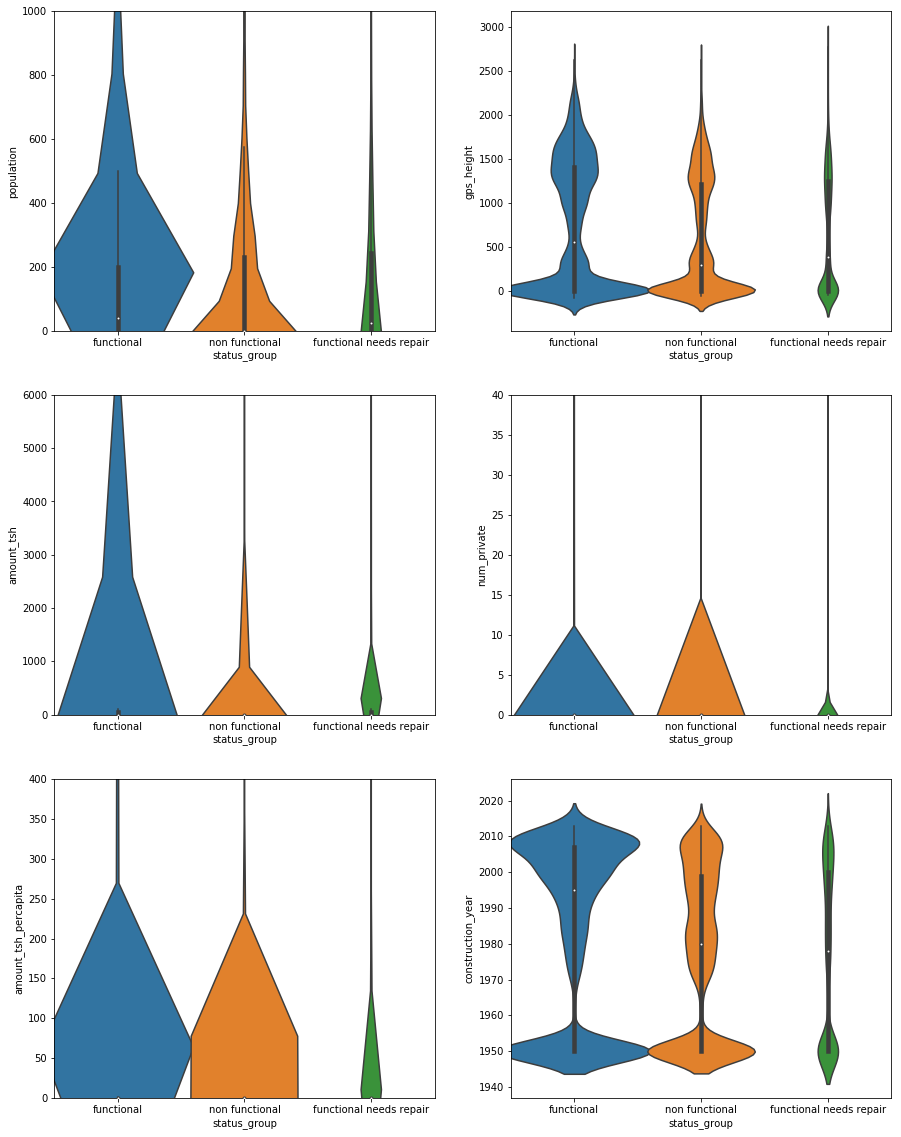

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(20)
sns.violinplot(x = 'status_group', y='population', data=df_join, ax=ax[0,0], scale='count', width=1.2)
sns.violinplot(x = 'status_group', y='amount_tsh', data=df_join,  ax=ax[1,0], scale='count', width=1.2)
sns.violinplot(x = 'status_group', y='amount_tsh_percapita', data=df_join, ax=ax[2,0], scale='count', width=1.2)
sns.violinplot(x = 'status_group', y='gps_height', data=df_join, ax=ax[0,1], scale='count', width=1.2)
sns.violinplot(x = 'status_group', y='num_private', data=df_join, ax=ax[1,1], scale='count', width=1.2)
sns.violinplot(x = 'status_group', y='construction_year', data=df_join, ax=ax[2,1], scale='count', width=1.2)
ax[0,0].set_ylim(0, 1000)
ax[1,0].set_ylim(0, 6000)
ax[2,0].set_ylim(0, 400)
ax[1,1].set_ylim(0, 40)

# <font color=blue> 2. Transforming categorical variables

In [25]:
df_cat_features=df_join.select_dtypes(exclude='number')
df_cat_features.columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

In [26]:
Ser1=df_cat_features.nunique()
Ser1.sort_values().head(30)

recorded_by                  1
status_group                 3
permit                       3
public_meeting               3
source_class                 3
quantity_group               5
quantity                     5
management_group             5
quality_group                6
waterpoint_type_group        6
waterpoint_type              7
payment_type                 7
extraction_type_class        7
source_type                  7
payment                      7
water_quality                8
basin                        9
source                      10
scheme_management           12
management                  12
extraction_type_group       13
extraction_type             18
region                      21
lga                        125
date_recorded              356
funder                    1897
installer                 1936
ward                      2092
scheme_name               2695
subvillage               19288
dtype: int64

In [27]:
Ser1.where(Ser1<=21).dropna()
#We will exclude 'region' as there is already a column named 'region_code'

basin                     9.0
region                   21.0
public_meeting            3.0
recorded_by               1.0
scheme_management        12.0
permit                    3.0
extraction_type          18.0
extraction_type_group    13.0
extraction_type_class     7.0
management               12.0
management_group          5.0
payment                   7.0
payment_type              7.0
water_quality             8.0
quality_group             6.0
quantity                  5.0
quantity_group            5.0
source                   10.0
source_type               7.0
source_class              3.0
waterpoint_type           7.0
waterpoint_type_group     6.0
status_group              3.0
dtype: float64

In [28]:
df_cat_features[Ser1.where(Ser1<=21).dropna().index].head()

,basin,region,public_meeting,recorded_by,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,Lake Nyasa,Iringa,True,GeoData Consultants Ltd,VWC,zero,gravity,gravity,gravity,vwc,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,Lake Victoria,Mara,nodata/none,GeoData Consultants Ltd,Other,True,gravity,gravity,gravity,wug,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,Pangani,Manyara,True,GeoData Consultants Ltd,VWC,True,gravity,gravity,gravity,vwc,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,Ruvuma / Southern Coast,Mtwara,True,GeoData Consultants Ltd,VWC,True,submersible,submersible,submersible,vwc,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,Lake Victoria,Kagera,True,GeoData Consultants Ltd,nodata/none,True,gravity,gravity,gravity,other,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### We can see that 
1. quantity & quantity_group are similar,
2. payment & payment_type are similar,
3. water_quality & quality group are similar
4. source, source_type & source class are similar
5. waterpoint_type & waterpoint_type_group are similar
6. scheme_management & management_group are similar
7. extraction_type, extraction_type_group & extraction_type_class are similar
8. "recorded_by" only have one value 
    * should hardly be a factor affecting the functionality of the waterpoint. 
9. "status_group" is the dependent variable y
#### For each group of similar features I choose one with most number of classes. After that, I can regroup the sparse classes into one unified class in my own way

[Text(0,0,'vwc'),
 Text(0,0,'wug'),
 Text(0,0,'other'),
 Text(0,0,'private operator'),
 Text(0,0,'water board'),
 Text(0,0,'wua'),
 Text(0,0,'company'),
 Text(0,0,'water authority'),
 Text(0,0,'parastatal'),
 Text(0,0,'unknown'),
 Text(0,0,'other - school'),
 Text(0,0,'trust')]

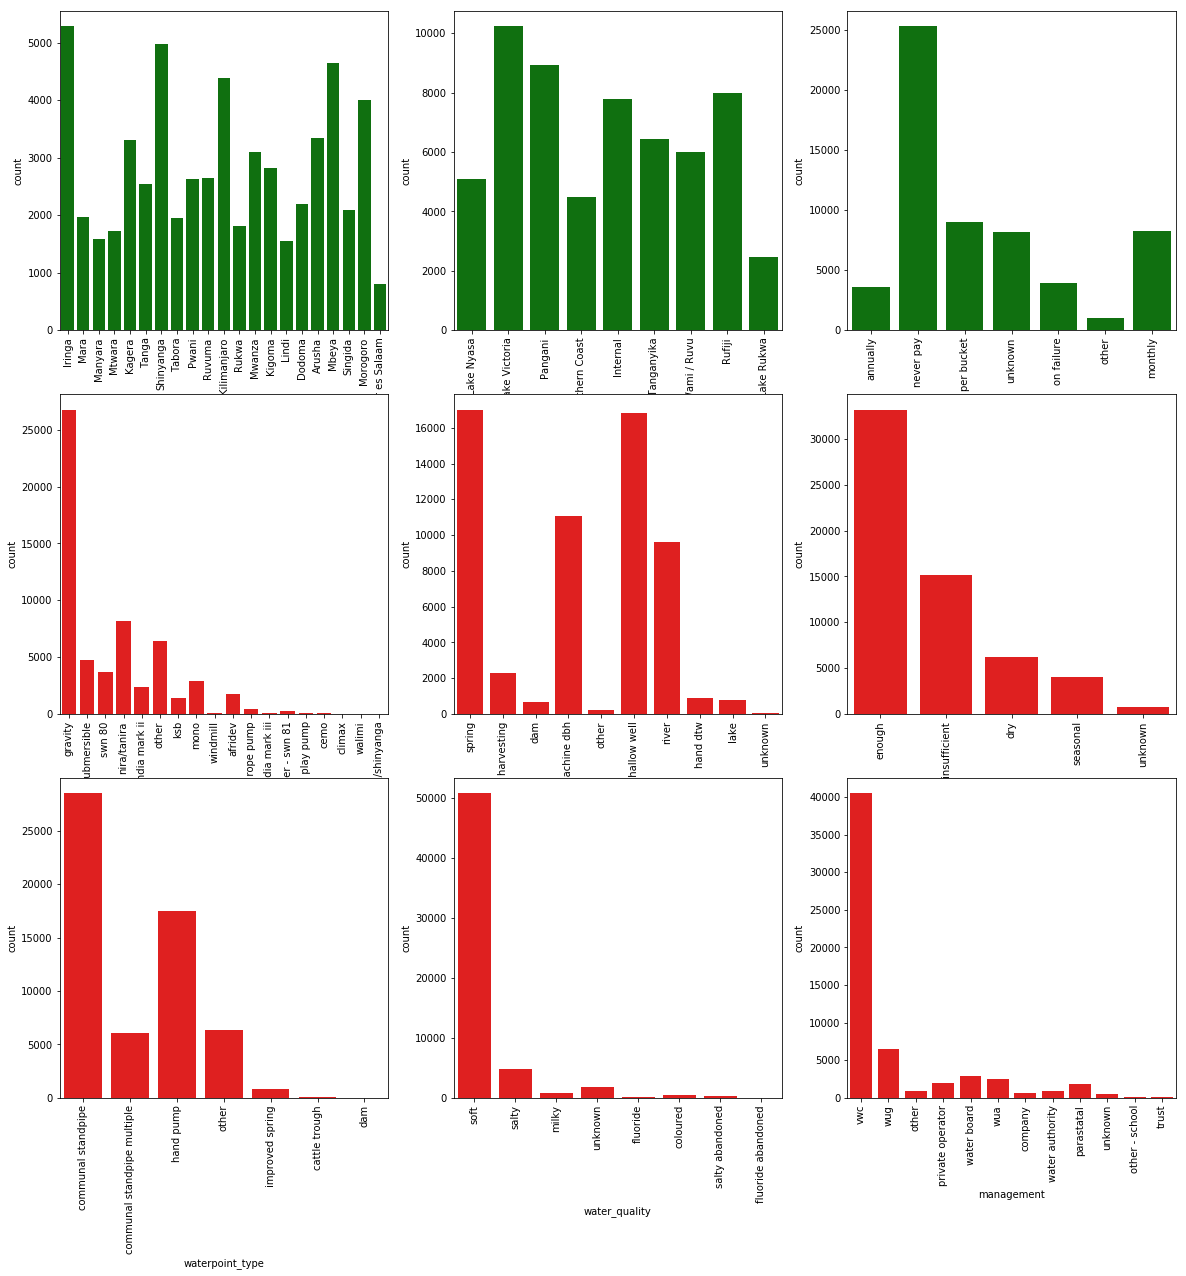

In [29]:
fig, ax = plt.subplots(ncols=3, nrows=3)
fig.set_figheight(20)
fig.set_figwidth(20)
sns.countplot(x='region', data=df_join, ax=ax[0][0], color='green')
sns.countplot(x='basin', data=df_join, ax=ax[0][1], color='green')
sns.countplot(x='payment_type', data=df_join, ax=ax[0][2], color='green')
sns.countplot(x='extraction_type', data=df_join, ax=ax[1][0], color='red')
sns.countplot(x='source', data=df_join, ax=ax[1][1], color='red')
sns.countplot(x='quantity', data=df_join, ax=ax[1][2], color='red')
sns.countplot(x='waterpoint_type', data=df_join, ax=ax[2][0], color='red')
sns.countplot(x='water_quality', data=df_join, ax=ax[2][1], color='red')
sns.countplot(x='management', data=df_join, ax=ax[2][2], color='red')
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=90)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=90)
ax[0][2].set_xticklabels(ax[0][2].get_xticklabels(), rotation=90)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=90)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=90)
ax[1][2].set_xticklabels(ax[1][2].get_xticklabels(), rotation=90)
ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=90)
ax[2][1].set_xticklabels(ax[2][1].get_xticklabels(), rotation=90)
ax[2][2].set_xticklabels(ax[2][2].get_xticklabels(), rotation=90)

### I see that some feature still have rare/sparse categories (low count). We can further group these entries (into a big others group for example). 
### The first 3 features (first row in green) can be left as they are
### For the ramining 6 features, let's group the categoories with num occurrences <0.5% total num of entries

In [30]:
df_cleaned.count()[0]*0.005

297.0

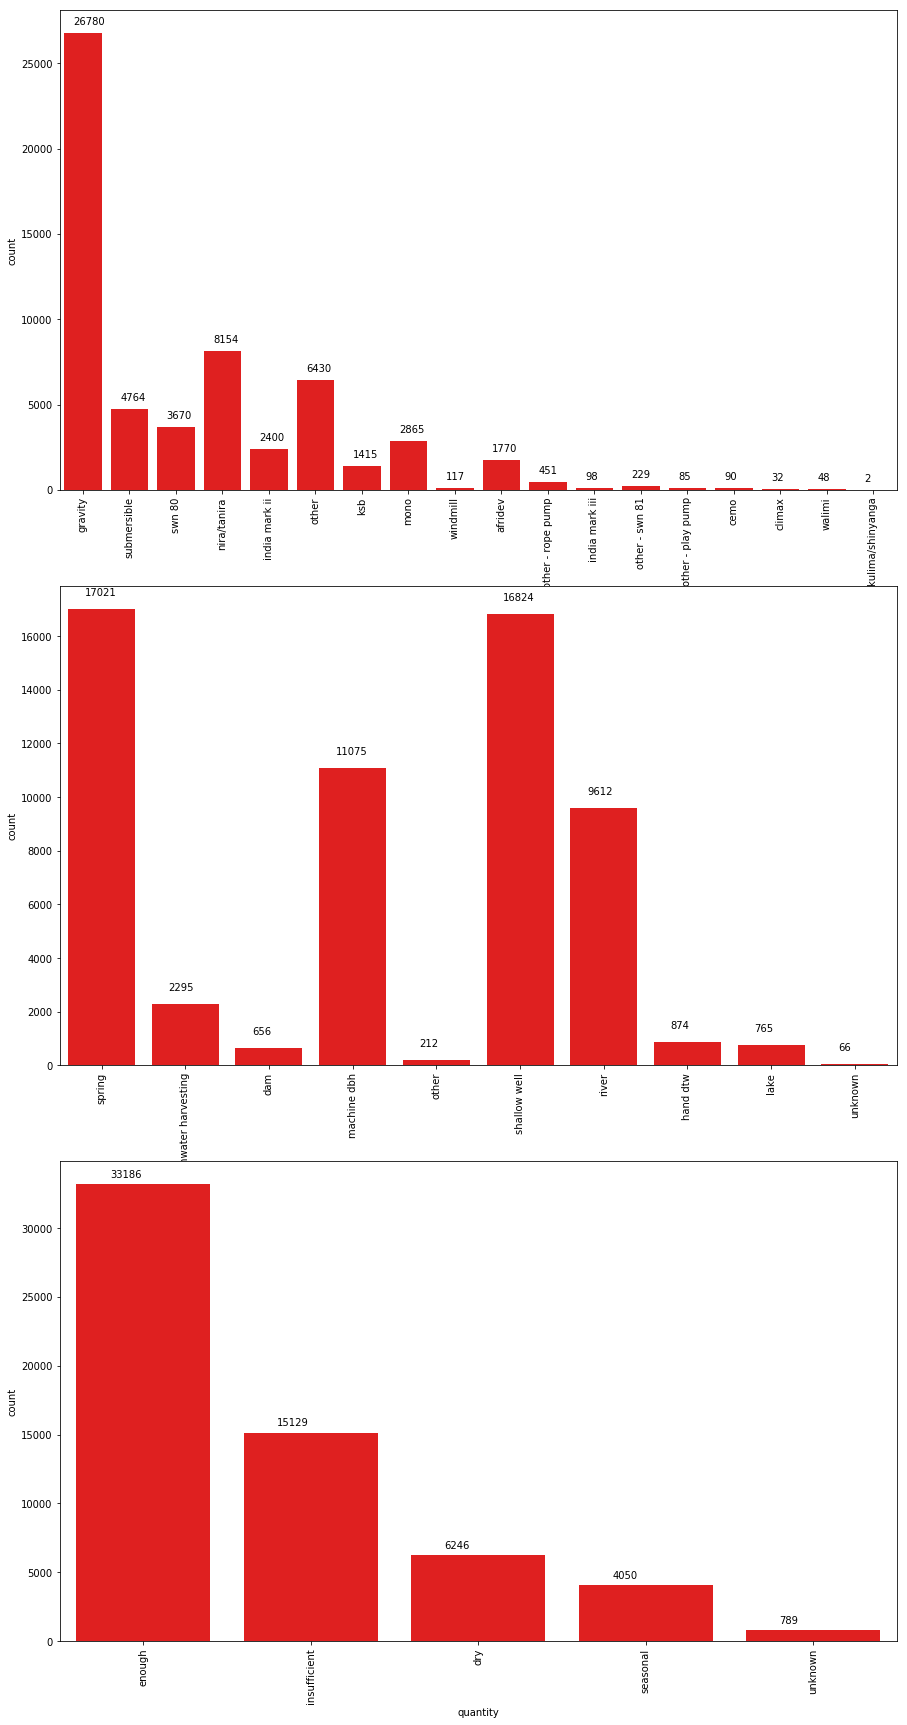

In [31]:
fig, ax = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(30)
fig.set_figwidth(15)
sns.countplot(x='extraction_type', data=df_join, ax=ax[0], color='red')
sns.countplot(x='source', data=df_join, ax=ax[1], color='red')
sns.countplot(x='quantity', data=df_join, ax=ax[2], color='red')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)

for j in range(3):
    ax_curr = ax[j]
    for p in ax_curr.patches:
        count = p.get_height()
        ax_curr.annotate(count, (p.get_x()+0.2, count+500))

In [32]:
df_join['extraction_type_regrouped'] = df_join['extraction_type'].apply(lambda x:x if x not in 
                                 ('windmill','india mark iii',
                                  'other - swn 81','other - play pump','cemo',
                                   'climax', 'walimi', 'other - mkulima/shinyanga') else 'others')
df_join['source_regrouped'] = df_join['source'].apply(lambda x:x if x not in
                                                      ('other','unknown') else 'others')

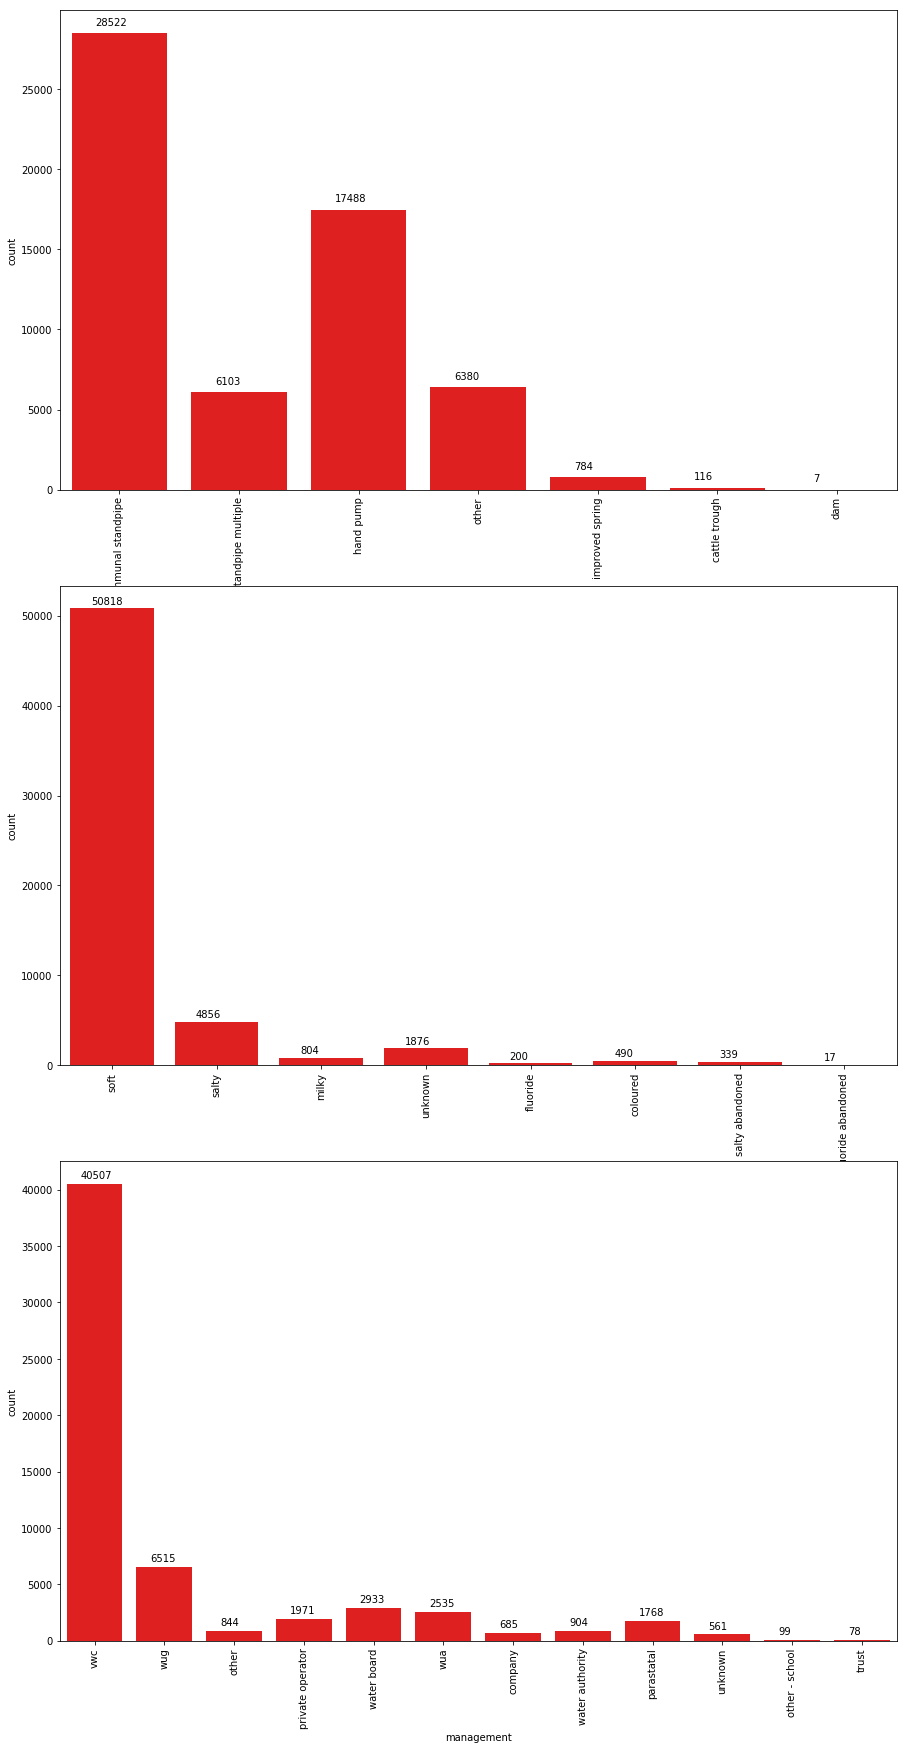

In [33]:
fig, ax = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(30)
fig.set_figwidth(15)
sns.countplot(x='waterpoint_type', data=df_join, ax=ax[0], color='red')
sns.countplot(x='water_quality', data=df_join, ax=ax[1], color='red')
sns.countplot(x='management', data=df_join, ax=ax[2], color='red')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
for j in range(3):
    ax_curr = ax[j]
    for p in ax_curr.patches:
        count = p.get_height()
        ax_curr.annotate(count, (p.get_x()+0.2, count+500))

In [34]:
df_join['waterpoint_type_regrouped'] = df_join['waterpoint_type'].apply(lambda x:x if x not in
                                        ('cattle trough', 'dam') else 'cattle trough/dam')
df_join['water_quality_regrouped'] = df_join['water_quality'].apply(lambda x:x if x not in
                                        ('fluoride','fluoride abandoned') else 'fluoride_group')
df_join['management_regrouped'] = df_join['management'].apply(lambda x:x if x not in
                                        ('other - school', 'trust') else 'school/trust')

In [35]:
#Let's transform these features into one_hot format (0 and 1 for each value which now each is a column)
df_transformed = pd.get_dummies(df_join, columns=['public_meeting','region','basin','payment_type','extraction_type_regrouped',
                                                  'permit','source_regrouped','quantity','waterpoint_type_regrouped',
                                                 'water_quality_regrouped', 'management_regrouped'], drop_first=True)
df_transformed.head()

,date_recorded,funder,installer,wpt_name,subvillage,lga,ward,recorded_by,scheme_management,scheme_name,...,management_regrouped_other,management_regrouped_parastatal,management_regrouped_private operator,management_regrouped_school/trust,management_regrouped_unknown,management_regrouped_vwc,management_regrouped_water authority,management_regrouped_water board,management_regrouped_wua,management_regrouped_wug
0,2011-03-14,roman,roman,nodata/none,Mnyusi B,Ludewa,Mundindi,GeoData Consultants Ltd,VWC,Roman,...,0,0,0,0,0,1,0,0,0,0
1,2013-03-06,grumeti,grumeti,Zahanati,Nyamara,Serengeti,Natta,GeoData Consultants Ltd,Other,nodata/none,...,0,0,0,0,0,0,0,0,0,1
2,2013-02-25,lottery club,world vision,Kwa Mahundi,Majengo,Simanjiro,Ngorika,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,...,0,0,0,0,0,1,0,0,0,0
3,2013-01-28,unicef,unicef,Zahanati Ya Nanyumbu,Mahakamani,Nanyumbu,Nanyumbu,GeoData Consultants Ltd,VWC,nodata/none,...,0,0,0,0,0,1,0,0,0,0
4,2011-07-13,action in a,artisan,Shuleni,Kyanyamisa,Karagwe,Nyakasimbi,GeoData Consultants Ltd,nodata/none,nodata/none,...,1,0,0,0,0,0,0,0,0,0


In [36]:
X = df_transformed.select_dtypes(exclude=object)
X.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year', 'amount_tsh_percapita',
       'public_meeting_nodata/none', 'public_meeting_zero',
       'region_Dar es Salaam', 'region_Dodoma', 'region_Iringa',
       'region_Kagera', 'region_Kigoma', 'region_Kilimanjaro', 'region_Lindi',
       'region_Manyara', 'region_Mara', 'region_Mbeya', 'region_Morogoro',
       'region_Mtwara', 'region_Mwanza', 'region_Pwani', 'region_Rukwa',
       'region_Ruvuma', 'region_Shinyanga', 'region_Singida', 'region_Tabora',
       'region_Tanga', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
       'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
       'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu',
       'payment_type_monthly', 'payment_type_never pay',
       'payment_type_on failure', 'payment_type_other',
       'payment_type_per bucket', 'payment_type_unknown',


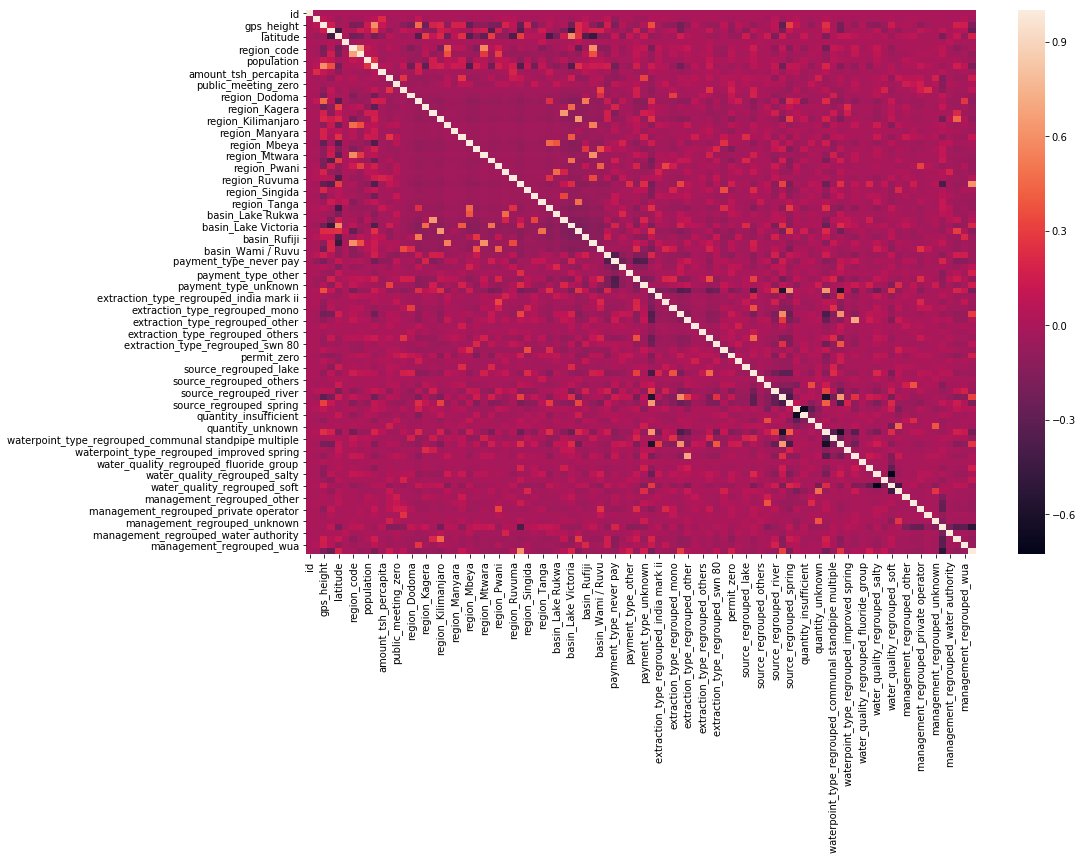

In [37]:
plt.figure(figsize=[15,10])
sns.heatmap(X.corr())

In [38]:
haha = X.corr()
for i in range(len(haha)):
    for j in range(len(haha)):
        curr_num = haha.iloc[i,j]
        if (curr_num<-0.7 or curr_num>0.7) and i<j:
            print('{} & {} = {}'.format(haha.index[i], haha.columns[j], curr_num))

extraction_type_regrouped_other & waterpoint_type_regrouped_other = 0.7084610992216364
water_quality_regrouped_salty & water_quality_regrouped_soft = -0.7260731491438969


### We can see that some categorical features have very high correlation with each other (not entirely independent features)
*These correlations may make the features appear to have more influence on the final label than it should be.

*Fitting a classifier on these highly correlated features may lead to overfitting (where we have high score for predictions of labels on the train set but not the test set  
*Let's remove 1 from each pair
    1. extration_type__regrouped_other & waterpoint_type_regrouped_other
    2. water_quality_regrouped_salty & water_quality_regrouped_soft

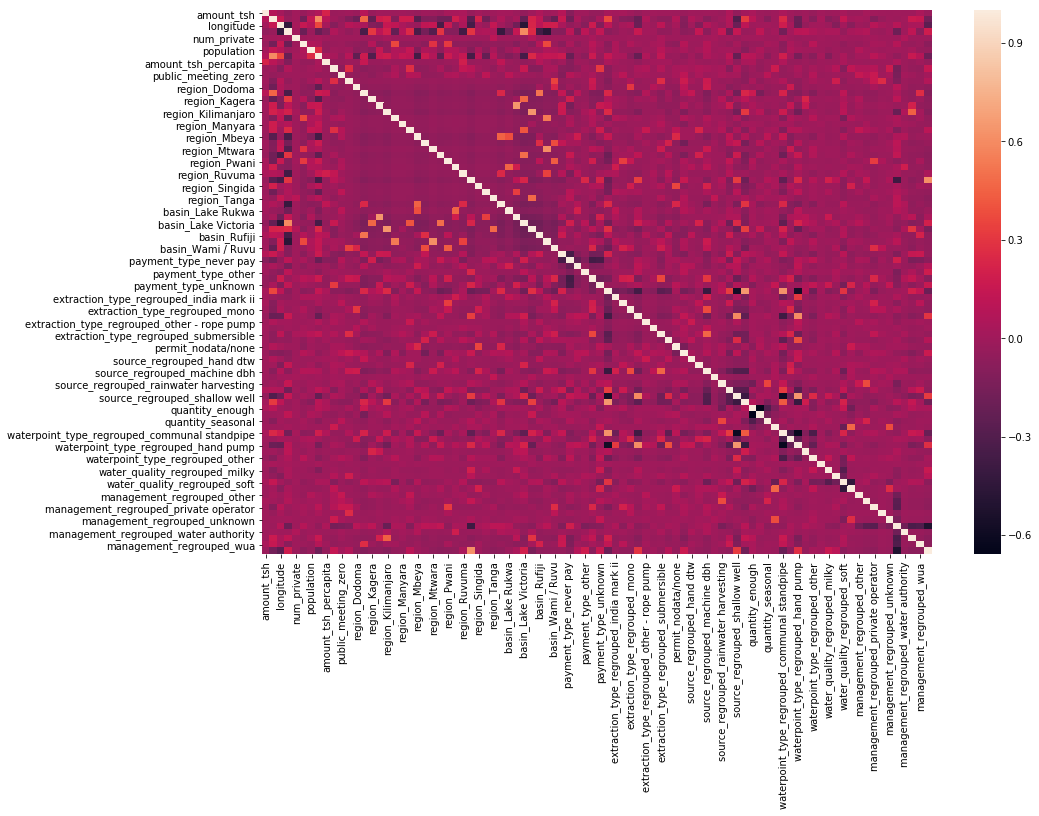

In [39]:
X = X.drop(labels=['id','region_code','extraction_type_regrouped_other'
                  ,'water_quality_regrouped_salty'], axis=1)
plt.figure(figsize=[15,10])
sns.heatmap(X.corr())

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
def cat_to_group(y_class):
    classes = list(set(y_class))
    classes.sort()
    dict1 = {j:i for i,j in enumerate(classes)}
    y_class_numeric = list(map(lambda x:dict1[x], y_class))
    return y_class_numeric, dict1

y = df_transformed['status_group']
y_trans, ctg_dict = cat_to_group(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=100)

# <font color=blue> 3. fitting a simple classifier first - Logistic Regression

In [41]:
from statsmodels.discrete.discrete_model import MNLogit, Logit, LogitResults

y_train_norm = [i/2 for i in y_train]
logi_simple = Logit(np.array(y_train_norm), np.array(X_train))
fitted=logi_simple.fit(maxiter=20, method='newton')
p_vals=fitted.pvalues
labels_to_drop = []
for i in range(len(p_vals)):
    a = X_train.columns[i]
    b = p_vals[i]
    if b>0.05:
        print(a, b)
        labels_to_drop.append(a)

Optimization terminated successfully.
         Current function value: 0.475618
         Iterations 8
num_private 0.5122929924090867
district_code 0.33675206782816325
amount_tsh_percapita 0.2620207238681498
public_meeting_nodata/none 0.23954275542008985
region_Mwanza 0.621923729858077
basin_Lake Rukwa 0.1255749831256647
basin_Lake Tanganyika 0.18850705666281808
basin_Lake Victoria 0.3793494232766641
basin_Rufiji 0.334520569180213
basin_Ruvuma / Southern Coast 0.10164645145819291
basin_Wami / Ruvu 0.9531728294305535
extraction_type_regrouped_mono 0.2815851175930352
extraction_type_regrouped_others 0.05471595021864254
permit_nodata/none 0.8573998684230105
source_regrouped_machine dbh 0.8259037759182866
waterpoint_type_regrouped_hand pump 0.1476576710407077
waterpoint_type_regrouped_improved spring 0.30139593383382524


In [42]:
X_train_dropped = X_train.drop(labels=labels_to_drop, axis=1)
X_test_dropped = X_test.drop(labels=labels_to_drop, axis=1)
from sklearn.model_selection import GridSearchCV
logi = LogisticRegressionCV(cv=4)
param_grid = {'Cs':[1,10,100]}
grid = GridSearchCV(logi, param_grid, verbose=1, scoring='accuracy')
grid.fit(X_train_dropped, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'Cs': [1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=1)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
print('Report for train instances')
y_pred_train = grid.predict(X_train_dropped)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))
print()
print('Report for test instances')
y_pred = grid.predict(X_test_dropped)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Report for train instances
[[23342    31  2465]
 [ 2790    93   568]
 [ 7103    37 11091]]
             precision    recall  f1-score   support

          0       0.70      0.90      0.79     25838
          1       0.58      0.03      0.05      3451
          2       0.79      0.61      0.69     18231

avg / total       0.73      0.73      0.70     47520


Report for test instances
[[5803    9  609]
 [ 684   30  152]
 [1769    9 2815]]
             precision    recall  f1-score   support

          0       0.70      0.90      0.79      6421
          1       0.62      0.03      0.07       866
          2       0.79      0.61      0.69      4593

avg / total       0.73      0.73      0.70     11880



In [44]:
print('GridSearch1 Mean Test score (different values corresponds to different classifiers) = {}'.format(grid.cv_results_['mean_test_score']))
print('GridSearch1 Mean Train score (different values corresponds to different classifiers) = {}'.format(grid.cv_results_['mean_train_score']))

GridSearch1 Mean Test score (different values corresponds to different classifiers) = [0.60951178 0.72396886 0.72319024]
GridSearch1 Mean Train score (different values corresponds to different classifiers) = [0.60996416 0.72485271 0.72368479]


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### we see that the data seems to not be so linearly separable. F1 score is bad and the recall for second and third class are bad. This classifier is actually not much better compared to a dummy classifier. The similarity between training vs test results also indicate that this classifier suffers from bias problem more than variance problem
* We can still take a glimpse at what are the important features in this classifier in deciding the classes of the data points
* This classifier actually consists of 3 different classifiers, one for each class (one vs other classifier). So there would be 3 sets of important features

In [45]:
classifier=grid.best_estimator_
list1=list(X_train_dropped.columns[np.argsort(classifier.coef_[0])[-3:]])
list2=list(X_train_dropped.columns[np.argsort(classifier.coef_[1])[-3:]])
list3=list(X_train_dropped.columns[np.argsort(classifier.coef_[2])[-3:]])
print('OVR classifier1 = {}\nOVR classifier2 = {}\nOVR classifier3 = {}'.format(list1,list2,list3))

OVR classifier1 = ['quantity_insufficient', 'quantity_seasonal', 'quantity_enough']
OVR classifier2 = ['quantity_insufficient', 'region_Kigoma', 'extraction_type_regrouped_gravity']
OVR classifier3 = ['region_Mara', 'waterpoint_type_regrouped_communal standpipe multiple', 'waterpoint_type_regrouped_other']


### First, let's visualise how the data is distributed across the various important features identified above

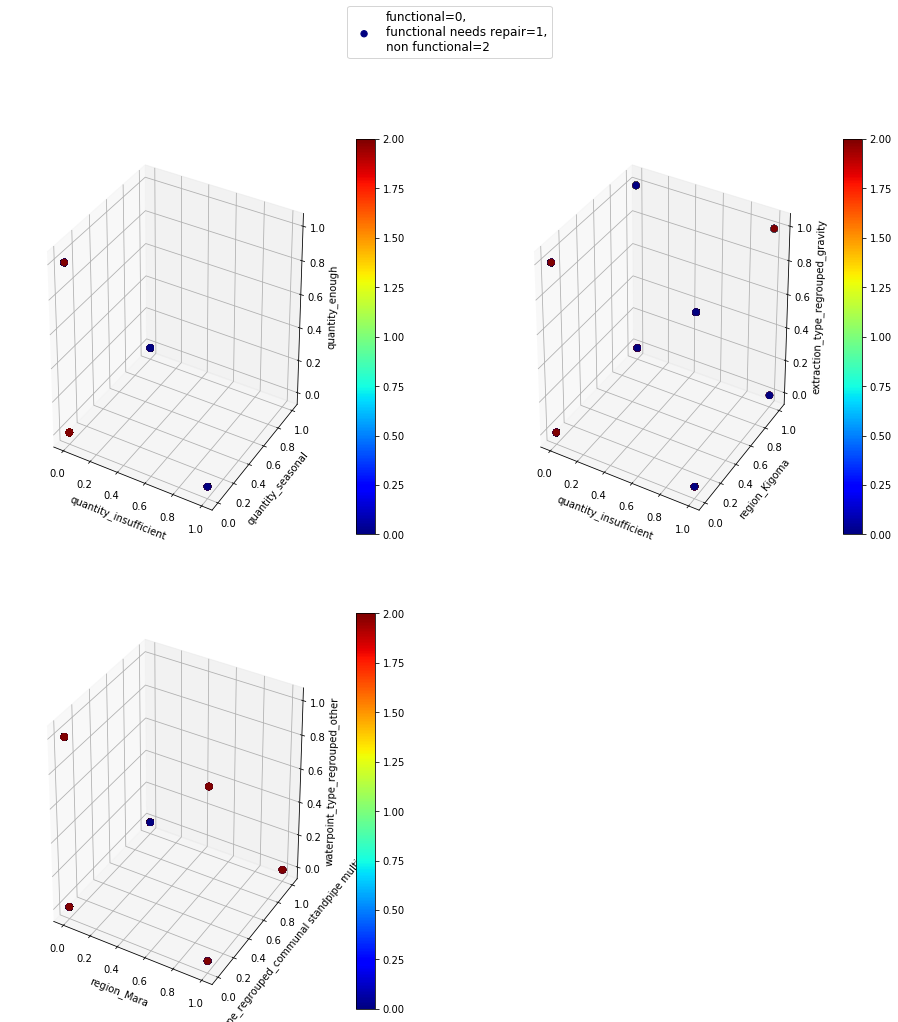

In [46]:
#Readers are encouraged to use the backend script below (temporarily commented out) to see the interactive 3D plot 
#%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import jet
class_list = list(ctg_dict.items())
fig = plt.figure(figsize=[16,16])
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
surf=ax1.scatter3D(xs=np.array(X_test[list1[0]]), ys=np.array(X_test[list1[1]]), zs=np.array(X_test[list1[2]])
              ,c=np.array(y_test),s=40, cmap=jet, depthshade=False,
             label='{}={},\n{}={},\n{}={}'.format(class_list[0][0], class_list[0][1],
                                        class_list[1][0], class_list[1][1],
                                        class_list[2][0], class_list[2][1]))
ax1.set_xlabel(list1[0])
ax1.set_ylabel(list1[1])
ax1.set_zlabel(list1[2])
ax2.scatter3D(xs=np.array(X_test[list2[0]]), ys=np.array(X_test[list2[1]]), zs=np.array(X_test[list2[2]])
              ,c=np.array(y_test), s=40, cmap=jet, depthshade=False,)
ax2.set_xlabel(list2[0])
ax2.set_ylabel(list2[1])
ax2.set_zlabel(list2[2])
ax3.scatter3D(xs=np.array(X_test[list3[0]]), ys=np.array(X_test[list3[1]]), zs=np.array(X_test[list3[2]])
              ,c=np.array(y_test), s=40, cmap=jet, depthshade=False)
ax3.set_xlabel(list3[0])
ax3.set_ylabel(list3[1])
ax3.set_zlabel(list3[2])

fig.colorbar(surf, ax=ax1)
fig.colorbar(surf, ax=ax2)
fig.colorbar(surf, ax=ax3)
fig.legend(loc=9, fontsize='large')

# <font color=blue> 4. Trying out a more advanced classifier: The Random Forest Classifier

In [47]:
print(y_train.count(0),y_train.count(1),y_train.count(2))

25838 3451 18231


In [48]:
from sklearn.ensemble import RandomForestClassifier
class_forest = RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, class_weight = {0:1,1:8,2:1.4}, n_jobs=10)
param_grid2 = {'n_estimators':[50,100,150]}
grid2 = GridSearchCV(class_forest, param_grid2, verbose=1, scoring='accuracy', cv=4)
grid2.fit(X_train, y_train)

y_pred2 = grid2.predict(X_test)
y_pred2_train = grid2.predict(X_train)
print('Report for train instances')
print(confusion_matrix(y_train, y_pred2_train))
print(classification_report(y_train, y_pred2_train))
print()
print('Report for test instances')
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   51.2s finished


Report for train instances
[[25577   238    23]
 [   11  3436     4]
 [   16    24 18191]]
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     25838
          1       0.93      1.00      0.96      3451
          2       1.00      1.00      1.00     18231

avg / total       0.99      0.99      0.99     47520


Report for test instances
[[5494  243  684]
 [ 396  325  145]
 [ 894   89 3610]]
             precision    recall  f1-score   support

          0       0.81      0.86      0.83      6421
          1       0.49      0.38      0.43       866
          2       0.81      0.79      0.80      4593

avg / total       0.79      0.79      0.79     11880



In [49]:
print('GridSearch2 Mean Test score (different values corresponds to different classifiers) = {}'.format(grid2.cv_results_['mean_test_score']))
print('GridSearch2 Mean Train score (different values corresponds to different classifiers) = {}'.format(grid2.cv_results_['mean_train_score']))

GridSearch2 Mean Test score (different values corresponds to different classifiers) = [0.79090909 0.79238215 0.7927399 ]
GridSearch2 Mean Train score (different values corresponds to different classifiers) = [0.99290825 0.99365881 0.99360269]


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Oopse it looks like we have a big variance/overfitting problem here as the forest classifier fits much better to the training set compared to the test set
### There are a few ways to reduce overfitting for a random forest
* increase number of samples for min_leaf and min_split (maybe from 1&2 to 2&4)
* reduce the amount of available features for each split in each tree. Current settings = sqrt(total num of features)
* limit the depth of each tree in the forest (may not be so effective in reducing variance)

# I will choose method 1

In [50]:
print('Inside the best estimator:')
num_features = grid2.best_estimator_.n_features_
print('num_features = {}, \nsqrt_num_features = {}, \nratio_of_max_features = {}'.format(num_features, 
                                                                                    np.sqrt(num_features),
                                                                                    np.sqrt(num_features)/num_features))
tree_depths = [estimator.tree_.max_depth for estimator in grid2.best_estimator_.estimators_]
print('max_tree_depth = {}'.format(max(tree_depths)))
print('avg_tree_depth = {}'.format(sum(tree_depths)/len(tree_depths)))
grid2.best_estimator_

Inside the best estimator:
num_features = 88, 
sqrt_num_features = 9.38083151964686, 
ratio_of_max_features = 0.10660035817780522
max_tree_depth = 51
avg_tree_depth = 42.28666666666667


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 8, 2: 1.4},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=10, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [51]:
num_estimators = grid2.best_estimator_.n_estimators
classifier2 = RandomForestClassifier(n_estimators=num_estimators, max_depth=50, 
                                     min_samples_leaf=2, min_samples_split=4,
                                     class_weight = {0:1,1:8,2:1.4}, n_jobs=10)
classifier2.fit(X_train, y_train)
y_pred3 = classifier2.predict(X_test)
y_pred3_train = classifier2.predict(X_train)
print('Report for train instances')
print(confusion_matrix(y_train, y_pred3_train))
print(classification_report(y_train, y_pred3_train))
print()
print('Report for test instances')
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Report for train instances
[[23380  1410  1048]
 [   90  3317    44]
 [ 1334   561 16336]]
             precision    recall  f1-score   support

          0       0.94      0.90      0.92     25838
          1       0.63      0.96      0.76      3451
          2       0.94      0.90      0.92     18231

avg / total       0.92      0.91      0.91     47520


Report for test instances
[[5178  549  694]
 [ 294  449  123]
 [ 766  215 3612]]
             precision    recall  f1-score   support

          0       0.83      0.81      0.82      6421
          1       0.37      0.52      0.43       866
          2       0.82      0.79      0.80      4593

avg / total       0.79      0.78      0.78     11880



## The variance between training & test set does get just a little bit better.
1. We reduced the fit to training set from 100% to 92% (in precision)
2. However, predictions on the test set seems to suffer slightly
3. We will use the original model (with min samples leaf/split = 1/2) as the final model

<font color=black>----------------------------------------------------------------------------------------</font>
## Visualising feature importances.  

1. The values for features importances are aggregated across the parallel trees
2. The the  most important features are those that reduce gini values the most among the splits of the forest. It is possible that these features are among the ones used to split the trees at the top of tree


Top 3 features are: ['longitude', 'latitude', 'gps_height']


[Text(0,0,'longitude'),
 Text(0,0,'latitude'),
 Text(0,0,'gps_height'),
 Text(0,0,'construction_year'),
 Text(0,0,'population'),
 Text(0,0,'district_code'),
 Text(0,0,'quantity_enough'),
 Text(0,0,'amount_tsh_percapita'),
 Text(0,0,'quantity_insufficient'),
 Text(0,0,'waterpoint_type_regrouped_other'),
 Text(0,0,'amount_tsh'),
 Text(0,0,'extraction_type_regrouped_gravity'),
 Text(0,0,'permit_zero'),
 Text(0,0,'management_regrouped_vwc'),
 Text(0,0,'payment_type_never pay'),
 Text(0,0,'quantity_seasonal'),
 Text(0,0,'waterpoint_type_regrouped_communal standpipe'),
 Text(0,0,'waterpoint_type_regrouped_hand pump'),
 Text(0,0,'water_quality_regrouped_soft'),
 Text(0,0,'source_regrouped_spring'),
 Text(0,0,'waterpoint_type_regrouped_communal standpipe multiple'),
 Text(0,0,'source_regrouped_river'),
 Text(0,0,'extraction_type_regrouped_nira/tanira'),
 Text(0,0,'payment_type_unknown'),
 Text(0,0,'payment_type_monthly')]

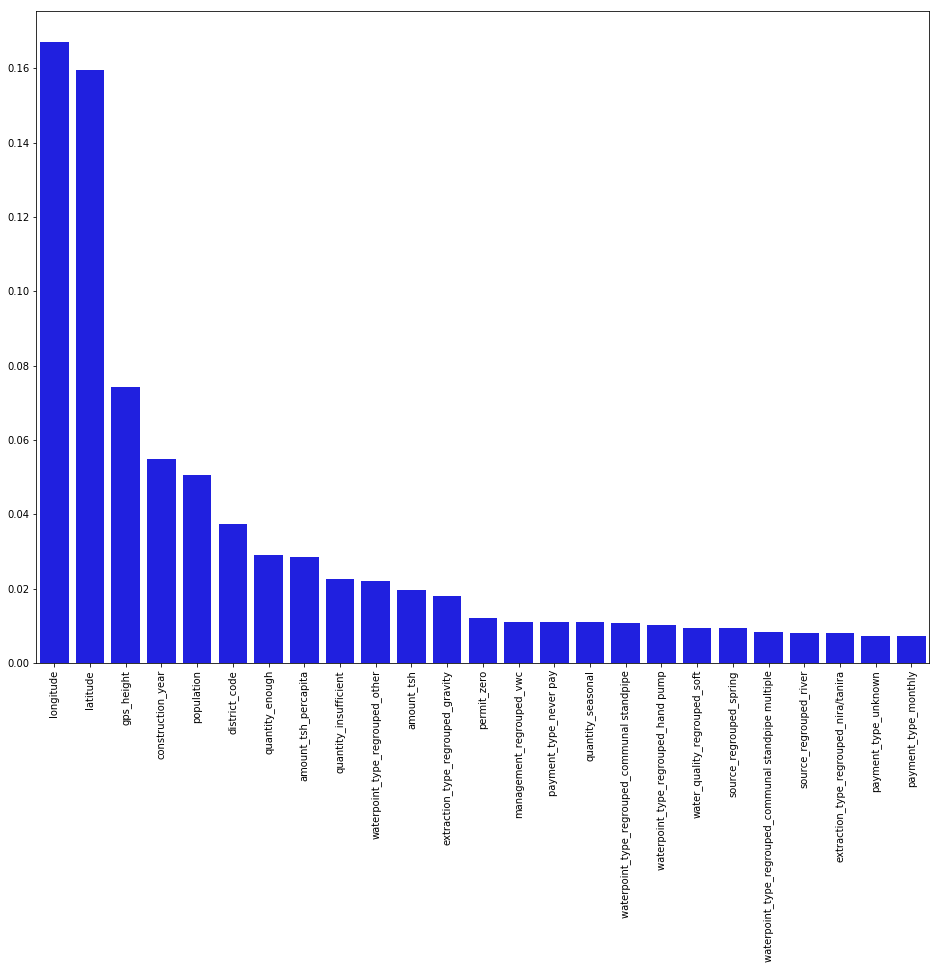

In [52]:
sorted_index = np.argsort(grid2.best_estimator_.feature_importances_)
feature_list_n_score = [(X_train.columns[i], grid2.best_estimator_.feature_importances_[i]) for i in sorted_index]
feature_list_n_score.reverse()
list4=[j[0] for j in feature_list_n_score[:3]]
print('Top 3 features are: {}'.format(list4))
plt.figure(figsize=[16,12])
#We will visualise the top quarter important features only (25 features)
plot_ax=sns.barplot([m[0] for m in feature_list_n_score[:25]], [m[1] for m in feature_list_n_score[:25]], color='blue')
plot_ax.set_xticklabels(labels=plot_ax.get_xticklabels(), rotation=90)

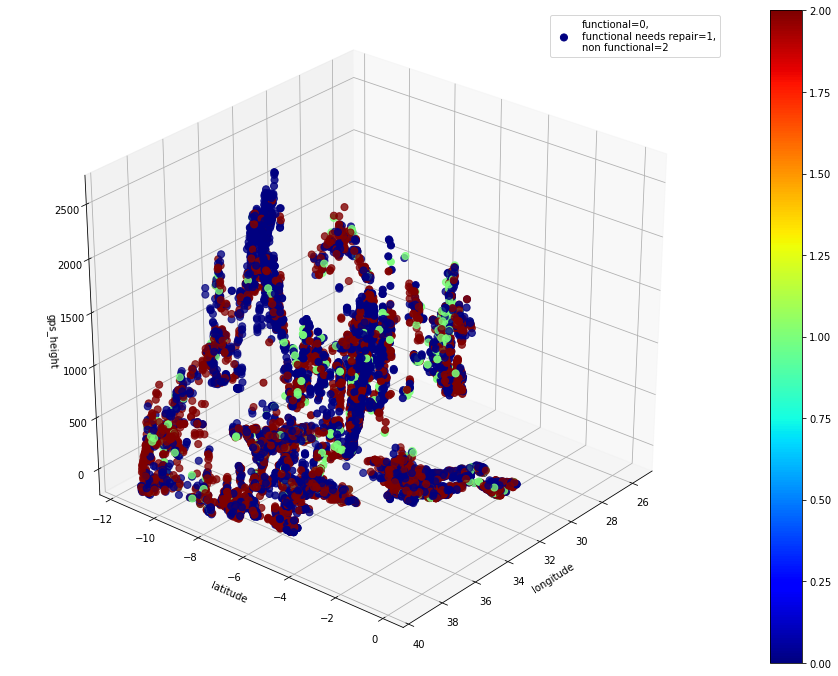

In [53]:
#Readers are encouraged to use the backend script below (temporarily commented out) to see the interactive 3D plot 
#%matplotlib qt
    
fig = plt.figure(figsize=[16,12])
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(25,40)
surf=ax.scatter3D(xs=np.array(X_test[list4[0]]), ys=np.array(X_test[list4[1]]), zs=np.array(X_test[list4[2]])
              ,c=np.array(y_test), cmap=jet, s=50,
                 label='{}={},\n{}={},\n{}={}'.format(class_list[0][0], class_list[0][1],
                                        class_list[1][0], class_list[1][1],
                                        class_list[2][0], class_list[2][1]))
fig.colorbar(surf, ax=ax)
ax.set_xlabel(list4[0])
ax.set_ylabel(list4[1])
ax.set_zlabel(list4[2])
ax.legend()
for angle in range(0, 360):
    ax.view_init(30, 40)

# <font color=blue> 5. Gradient Boosting Collection of Trees
    -------------------------------
<font size=3>

1. This model is a collection of weak mini-classifiers where each mini-classifier learns from the mistakes (classification errors) of its predecessor


2. For this classifier, we will first attempt min_samples_leaf/split = 1/2 to check if there is overfitting


3. We chose max_depth = 10. This ensures that each learner is "weak" enough but not too weak to induce large bias

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
class_boost = GradientBoostingClassifier(min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150, max_depth=10)
class_boost.fit(X_train, y_train)
y_pred4 = class_boost.predict(X_test)
y_pred4_train = class_boost.predict(X_train)
print('Report for train instances')
print(confusion_matrix(y_train, y_pred4_train))
print(classification_report(y_train, y_pred4_train))
print()
print('Report for test instances')
print(confusion_matrix(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Report for train instances
[[25437    81   320]
 [  762  2561   128]
 [ 1259    33 16939]]
             precision    recall  f1-score   support

          0       0.93      0.98      0.95     25838
          1       0.96      0.74      0.84      3451
          2       0.97      0.93      0.95     18231

avg / total       0.95      0.95      0.94     47520


Report for test instances
[[5710  145  566]
 [ 464  268  134]
 [ 948   62 3583]]
             precision    recall  f1-score   support

          0       0.80      0.89      0.84      6421
          1       0.56      0.31      0.40       866
          2       0.84      0.78      0.81      4593

avg / total       0.80      0.80      0.80     11880



In [55]:
sorted_index = np.argsort(class_boost.feature_importances_)
feature_list_n_score = [(X_train.columns[i], classifier2.feature_importances_[i]) for i in sorted_index]
feature_list_n_score.reverse()
list4=[j[0] for j in feature_list_n_score[:3]]
print('Top 3 features are: {}'.format(list4))

Top 3 features are: ['longitude', 'latitude', 'gps_height']


## NOT BAD! I will submit separate predictions from both and see which one performs better
<font color=black>----------------------------------------------------------------------------------------------

<font color=blue>
# 5. Applying the model to the unlabeled test set (provided by Driven Data)

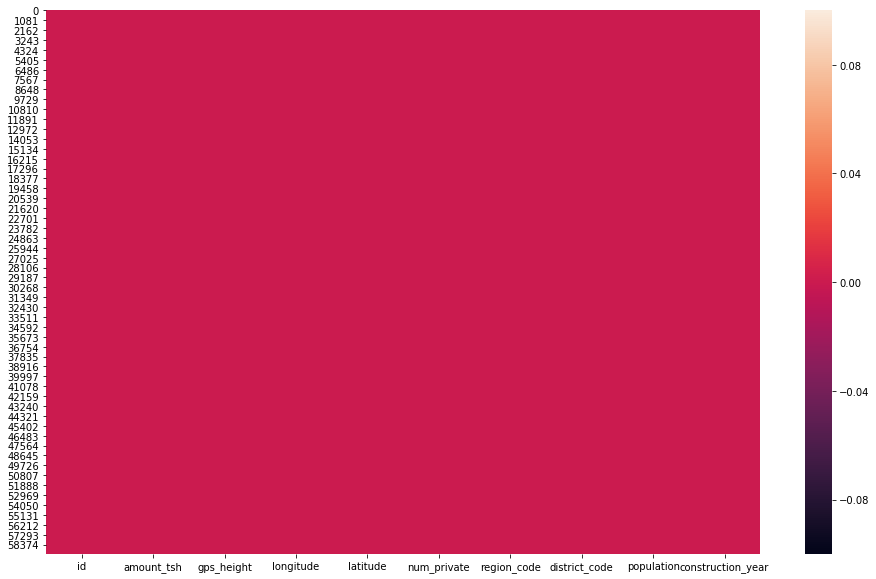

In [56]:
df_test =  pd.read_csv('Test_Set.csv')
df_test[['funder','installer']]=df_test[['funder','installer']].applymap(lambda x:x.lower() if isinstance(x, str) else x)
#This function is to lower case all etries in 'funder' and 'installer'
plt.figure(figsize=[16,10])
df_num_test = df_test.select_dtypes(include='number', exclude=object)
sns.heatmap(df_num.isna())

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


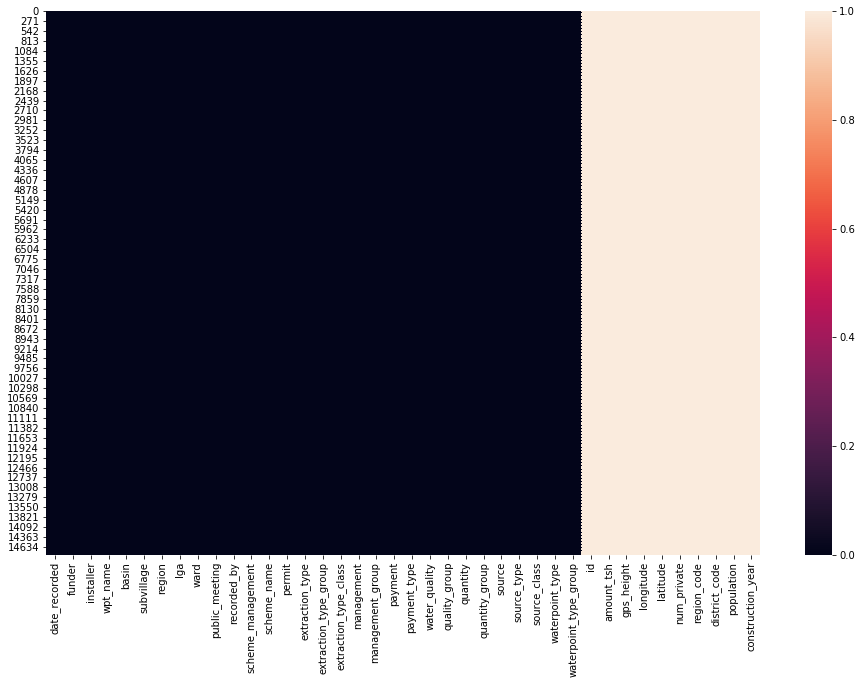

In [57]:
df_obj_test = df_test.select_dtypes(exclude='number')
df_obj_test.replace(value=['nodata/none','nodata/none','nodata/none','nodata/none','zero','zero','zero'], 
                                            to_replace=['NaN','None','none',np.NaN,'0',0,0.0], inplace=True)
df_cleaned_test = pd.concat(objs=[df_obj_test, df_num_test], axis=1)
plt.figure(figsize=[16,10])
df_check_test = df_cleaned_test.applymap(lambda x:1 if ((isinstance(x, int) or isinstance(x, float)) 
                                              and not isinstance(x, bool)) else 0)
sns.heatmap(df_check_test)

In [58]:
X_real_test = df_cleaned_test
X_real_test['construction_year'].replace(to_replace=0, value=1950, inplace=True)
X_real_test['amount_tsh_percapita'] = list(map(lambda x,y: x/(y+1), 
                                           X_real_test['amount_tsh'], X_real_test['population']))

X_real_test['extraction_type_regrouped'] = X_real_test['extraction_type'].apply(lambda x:x if x not in 
                                 ('windmill','india mark iii',
                                  'other - swn 81','other - play pump','cemo',
                                   'climax', 'walimi', 'other - mkulima/shinyanga') else 'others')
X_real_test['source_regrouped'] = X_real_test['source'].apply(lambda x:x if x not in
                                                      ('other','unknown') else 'others')
X_real_test['waterpoint_type_regrouped'] = X_real_test['waterpoint_type'].apply(lambda x:x if x not in
                                        ('cattle trough', 'dam') else 'cattle trough/dam')
X_real_test['water_quality_regrouped'] = X_real_test['water_quality'].apply(lambda x:x if x not in
                                        ('fluoride','fluoride abandoned') else 'fluoride_group')
X_real_test['management_regrouped'] = X_real_test['management'].apply(lambda x:x if x not in
                                        ('other - school', 'trust') else 'school/trust')

X_real_test = pd.get_dummies(X_real_test, columns=['public_meeting','region','basin','payment_type','extraction_type_regrouped',
                                                  'permit','source_regrouped','quantity','waterpoint_type_regrouped',
                                                 'water_quality_regrouped', 'management_regrouped'], drop_first=True)

X_real_test = X_real_test.drop(labels=['id','region_code','extraction_type_regrouped_other'
                  ,'water_quality_regrouped_salty'], axis=1)
X_real_test = X_real_test.select_dtypes(exclude=object)

In [59]:
a = set(X_real_test.columns)
b = set(X_train.columns)
b.difference_update(a)
print(b)

set()


In [61]:
#Make sure training set and test set has the same number of features
#Then retrain the 2 models on the entire training set, instead of just 0.75 of it
grid2.best_estimator_.fit(X, y_trans)
class_boost.fit(X, y_trans)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [62]:
y_pred_test_1 = grid2.best_estimator_.predict(X_real_test)
y_pred_test_2 = class_boost.predict(X_real_test)
class_dict_reverse = {i[1]: i[0] for i in list(class_list)}
y_pred_test_string_1 = list(map(lambda x: class_dict_reverse[x], y_pred_test_1))
y_pred_test_string_2 = list(map(lambda x: class_dict_reverse[x], y_pred_test_2))
y_pred_test_string_1[:5]

['non functional', 'functional', 'functional', 'non functional', 'functional']

In [63]:
df_test['prediction_random_forest'] = y_pred_test_string_1
df_test['prediction_gradient_boost'] = y_pred_test_string_2
df_test.to_csv('Test_prediction_2.csv')

# <font color=red> My submission got accuracy of 
   <font size=3> 
    A. 0.8091 for the Random Forest Model and  
    B. 0.8125 for the Gradient Boosting Model. Wow!  
   <font size=3>  
    I am currently ranked at 794/6219 (top 13% of the cohort). Not bad!, though I originally aimed to get into top 10%. 
<font color = black>--------------------------------------------------------------------------------------</font>
## Let's see if I can do better with deep learning?

<font color=blue>
# Bonus 1: Attempting a Neural Network for classifier

In [64]:
from keras.utils import to_categorical
def define_model(X_train, y_train, num_layers, num_units, activations, epochs, batch_size):
    '''
    num_units = list of int correspond to num of units for each layer
                Num of elements in num_units = num_layers
                Last layer = output layer should have num_unit = number of classes
    
    activations = list of -s type correspond to name of activation function for each layer
                Values = either 'tanh' or 'relu' for hidden layers
                Last layer = output layer should have activation =
                1. softmax for multiple labels
                2. sigmoid for 0 and 1 labels
    '''
    assert len(num_units) == num_layers
    assert num_units[-1] == len(set(y_train))
    assert len(activations) == num_layers
    if len(set(y_train))<=2:
        assert activations[-1] == 'sigmoid' 
    else:
        assert activations[-1] == 'softmax'
    
    dim = X_train.shape[1]
    model = K.Sequential()
    model.add(K.layers.Dense(units=num_units[0], activation=activations[0], input_dim=dim))
    for i in range(1, num_layers):
        model.add(K.layers.Dense(units=num_units[i], activation=activations[i]))
    
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    y_train_binary = to_categorical(y_train)
    model.fit(X_train, y_train_binary, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

In [69]:
model1 = 0
model1 = define_model(X_train, y_train, num_layers=2, num_units=[44,3], 
                      activations=['relu','softmax'], epochs=20, batch_size=32)

Epoch 1/20
47520/47520 [==============================] - 2s 37us/step - loss: 3.3215 - acc: 0.6923
Epoch 2/20
47520/47520 [==============================] - 1s 31us/step - loss: 1.0951 - acc: 0.7519
Epoch 3/20
47520/47520 [==============================] - 1s 31us/step - loss: 1.0606 - acc: 0.7550
Epoch 4/20
47520/47520 [==============================] - 2s 32us/step - loss: 1.0484 - acc: 0.7576
Epoch 5/20
47520/47520 [==============================] - 1s 31us/step - loss: 0.9874 - acc: 0.7662
Epoch 6/20
47520/47520 [==============================] - 2s 33us/step - loss: 0.9860 - acc: 0.7660
Epoch 7/20
47520/47520 [==============================] - 2s 33us/step - loss: 0.9958 - acc: 0.7672
Epoch 8/20
47520/47520 [==============================] - 2s 33us/step - loss: 0.9660 - acc: 0.7677
Epoch 9/20
47520/47520 [==============================] - 2s 34us/step - loss: 0.9692 - acc: 0.7697
Epoch 10/20
47520/47520 [==============================] - 2s 32us/step - loss: 0.9503 - acc: 0.7706

In [70]:
model1.evaluate(X_test, to_categorical(y_test), batch_size=32)

11880/11880 [==============================] - 0s 20us/step


[0.7905946444582056, 0.8057239198524141]

In [73]:
model2=0
model2 = define_model(X_train, y_train, num_layers=2, num_units=[48,3], 
                      activations=['relu','softmax'], epochs=20, batch_size=32)

Epoch 1/20
47520/47520 [==============================] - 2s 39us/step - loss: 4.9343 - acc: 0.6919
Epoch 2/20
47520/47520 [==============================] - 2s 34us/step - loss: 4.8761 - acc: 0.6958
Epoch 3/20
47520/47520 [==============================] - 2s 33us/step - loss: 4.8761 - acc: 0.6958
Epoch 4/20
47520/47520 [==============================] - 1s 31us/step - loss: 4.8761 - acc: 0.6958
Epoch 5/20
47520/47520 [==============================] - 1s 30us/step - loss: 4.8761 - acc: 0.6958
Epoch 6/20
47520/47520 [==============================] - 1s 30us/step - loss: 4.8761 - acc: 0.6958
Epoch 7/20
47520/47520 [==============================] - 1s 31us/step - loss: 4.8761 - acc: 0.6958
Epoch 8/20
47520/47520 [==============================] - 2s 32us/step - loss: 4.8761 - acc: 0.6958
Epoch 9/20
47520/47520 [==============================] - 2s 33us/step - loss: 4.8761 - acc: 0.6958
Epoch 10/20
47520/47520 [==============================] - 2s 45us/step - loss: 4.8761 - acc: 0.6958

In [74]:
model2.evaluate(X_test, to_categorical(y_test), batch_size=32)

11880/11880 [==============================] - 0s 22us/step


[4.91072245029488, 0.6936588201859984]

In [75]:
y_pred_test_3 = model1.predict_classes(X_real_test)
y_pred_test_string_3 = list(map(lambda x: class_dict_reverse[x], y_pred_test_3))
y_pred_test_string_3[:5]
df_test['prediction_gradient_neural_net'] = y_pred_test_string_3
df_test.to_csv('Test_prediction_2.csv')

## Conclusion
### * No the neural network does not do better than the random forest classifier, or the Gradient Boosting Tree Machine. 
### * However, model 1 may compete. Let's find which of the three models predicts the best from the submission result

# <font color=blue> Bonus 2: Visualisng latitude and longitude of the wells using real map

In [ ]:
import cufflinks as cf
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

In [ ]:
cf.go_offline()
init_notebook_mode(connected=True)

In [ ]:
dict1 = {class_list[0][1]:jet(0.0), class_list[1][1]:jet(0.5), class_list[2][1]:jet(1.0)}

data = [go.Choropleth(locations = ['TZA'],
            locationmode = 'ISO-3',
            colorscale= 'Jet',
            text= 'Tanzania',
            colorbar = {'title':'Colorbar Title'},
            showlegend=True),
       go.Scattergeo(lat=X['latitude'], lon=X['longitude'], 
                              marker = dict(size=5, color=list(map(lambda x: 'rgba{}'.format(dict1[x]), y)))
                     )
       ]
layout = dict(title = "Well's status distribution in Tanzania",
              geo = dict(scope='africa',
                         bgcolor='lightgrey',
                        projection = dict(type = 'mercator')
                        ),
              legend = dict(font=dict(size=4)),
                )               
full_map = go.Figure(data=data, layout=layout)

In [ ]:
#comment out to see the graph
#iplot(full_map)